In [1]:
import sys
#sys.path.insert(0, '../third/xgboost.m/python-package/build/lib/')
sys.path.insert(0, '../third/xgboost/python-package/build/lib/')

In [2]:
%pylab inline
import pandas as pd
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [44]:
from quadratic_weighted_kappa import quadratic_weighted_kappa

In [5]:
xgb.__version__,xgb.__file__

('0.6', '../third/xgboost/python-package/build/lib/xgboost/__init__.pyc')

In [55]:
import fastparquet
%time df=fastparquet.ParquetFile("../input/train_test_num_net_step1.parq").to_pandas()
df=df.drop(['date','rid'],axis=1)

CPU times: user 2.34 s, sys: 1.62 s, total: 3.96 s
Wall time: 3.95 s


In [56]:
df.shape

(6582476, 43)

In [57]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6582476 entries, 10000000 to 1378520
Columns: 43 entries, market to target
dtypes: float32(41), float64(1), int8(1)
memory usage: 1.1 GB


In [13]:
(df.index<10000000).sum(),(df.target<0).sum()

(1378521, 1378521)

In [59]:
testx=df[df.index<10000000].drop('target',axis=1)
testx.shape

(1378521, 42)

In [14]:
df=df[df.index>=10000000]

In [15]:
df.shape

(5203954, 45)

In [16]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5203954 entries, 10000001 to 15203954
Columns: 45 entries, market to rid
dtypes: float32(41), float64(1), int64(1), int8(2)
memory usage: 942.9 MB


In [20]:
df=df.loc[np.random.permutation(df.index)]

In [25]:
import gc
gc.collect()

204

In [26]:
df.head()

market       f_0       f_1       f_2       f_3       f_4  \
id                                                                     
10684532  4.658483  4.659207  4.589514  4.576220  0.000000  0.000000   
12870399  4.615890  4.682021  4.589514  4.622002  1.432530  1.407307   
14852968  4.600824  4.458380  4.715542  4.610031  0.113882  0.487933   
11297774  4.452262  4.682021  4.589514  4.622002  0.733754  0.444744   
12571878  4.658483  4.458380  4.256005  4.576220  2.426301  1.431494   

               f_5  f_6       f_7       f_8   ...        f_33      f_34  \
id                                            ...                         
10684532  7.959006  0.0  4.791041  1.492079   ...    4.744621  1.094772   
12870399  6.361315  0.0  5.125340  1.183172   ...    4.839049  1.094772   
14852968  2.279448  0.0  4.896781  1.001795   ...    4.217763  1.094772   
11297774  2.859509  0.0  4.301865  1.096068   ...    4.755675  1.094772   
12571878  6.361315  0.0  4.213173  1.523014   ...    3.957714  1.094772   

              f_35      f_36  f_37      f_38  f_39      f_40      f_41  target  
id                                                                              
10684532  0.129142  3.928549   0.0  2.511307   0.0 -0.000086  0.000000       4  
12870399  0.048059  5.041609   0.0  0.000000   0.0  0.000013  4.210556       4  
14852968  0.000000  0.814431   0.0  0.000000   0.0 -0.000083  0.814431       1  
11297774  0.012841  3.617565   0.0  0.000000   0.0 -0.000050  2.828953       2  
12571878  0.099230  4.303015   0.0  0.000000   0.0  0.000086  4.129573       9  

[5 rows x 43 columns]

In [27]:
trainx=df.drop(['target'],axis=1)
trainy=df['target']

In [28]:
trainx.shape

(5203954, 42)

In [29]:
5203954*.8

4163163.2

In [30]:
split = 4163163
x_train, y_train, x_valid, y_valid = trainx[:split], trainy[:split], trainx[split:], trainy[split:]

print('Building DMatrix...')

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)




Building DMatrix...


In [31]:
x_train.shape,x_valid.shape

((4163163, 42), (1040791, 42))

In [35]:
print('Training ...')

params = {}
params['eta'] = 0.2
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['max_depth'] = 8
params['nthread']=8
params['silent'] = 1
params['tree_method']='hist'

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
%time clf = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50,verbose_eval=40)


Training ...
[0]	train-rmse:4.22045	valid-rmse:4.21774
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:2.01013	valid-rmse:2.011
[20]	train-rmse:1.95747	valid-rmse:1.96247
[30]	train-rmse:1.94934	valid-rmse:1.95752
[40]	train-rmse:1.94404	valid-rmse:1.95538
[50]	train-rmse:1.93931	valid-rmse:1.95354
[60]	train-rmse:1.93521	valid-rmse:1.95213
[70]	train-rmse:1.93148	valid-rmse:1.95102
[80]	train-rmse:1.92785	valid-rmse:1.95009
[90]	train-rmse:1.9241	valid-rmse:1.94919
[100]	train-rmse:1.92101	valid-rmse:1.94834
[110]	train-rmse:1.91786	valid-rmse:1.94783
[120]	train-rmse:1.91487	valid-rmse:1.94725
[130]	train-rmse:1.91203	valid-rmse:1.94674
[140]	train-rmse:1.90904	valid-rmse:1.94614
[150]	train-rmse:1.90615	valid-rmse:1.94576
[160]	train-rmse:1.90362	valid-rmse:1.94534
[170]	train-rmse:1.90106	valid-rmse:1.94493
[180]	train-rmse:1.89861	valid-rmse:1.94446
[190]	train-rmse:1.8

In [129]:
def scale_pred(y_true, y_pred):
    B=np.mean((y_true-y_true.mean())**2)
    C=np.mean((y_pred-y_pred.mean())**2)
    A=np.mean((y_true-y_pred)**2)
    
    print A,B,C, (C-A+B)/(C+B)
    
    b=np.arange(-1,1.3,0.01)
    bb=(b*(C-A)+B)/(C+b**2*B)
    print max(bb)
    plt.plot(b,bb)
    return (B/(A-C))
def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

In [95]:
pred=clf.predict(d_valid)

In [144]:
lst=[]
for s in np.arange(1.25,1.35,0.01):
    a= s, quadratic_weighted_kappa(y_valid,clip_pred((pred-pred.mean())*s+pred.mean()))
    print a
    lst.append(a)

(1.25, 0.7530724741553593)
(1.26, 0.7533494640478346)
(1.27, 0.7536198836932538)
(1.28, 0.7538534794824313)
(1.29, 0.7539777707960562)
(1.3, 0.7541041007884324)
(1.3100000000000001, 0.7541407441308691)
(1.3200000000000001, 0.754221003246697)
(1.3300000000000001, 0.7541922782582562)
(1.3400000000000001, 0.7541914418615073)
(1.3500000000000001, 0.7540722070974266)


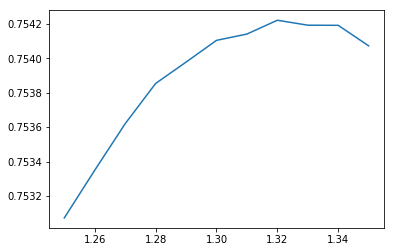

In [148]:
plt.plot(np.array(lst).T[0],np.array(lst).T[1])

In [151]:
lst=[]
for s in np.arange(1.1,1.8,0.05):
    a= s, quadratic_weighted_kappa(y_valid,clip_pred((pred-pred.mean())*s+pred.mean()))
    print a
    lst.append(a)

(1.1000000000000001, 0.7416075922011569)
(1.1500000000000001, 0.746875372737604)
(1.2000000000000002, 0.7507174324472292)
(1.2500000000000002, 0.7530724741553593)
(1.3000000000000003, 0.7541041007884324)
(1.3500000000000003, 0.7540722070974266)
(1.4000000000000004, 0.7529593240053778)
(1.4500000000000004, 0.7511576361242618)
(1.5000000000000004, 0.7486562026181447)
(1.5500000000000005, 0.7453803466203678)
(1.6000000000000005, 0.7416266114728559)
(1.6500000000000006, 0.7376316279006104)
(1.7000000000000006, 0.733300809377689)
(1.7500000000000007, 0.7286133385458287)


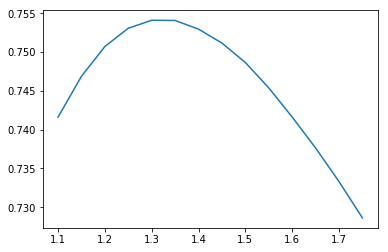

In [152]:
plt.plot(np.array(lst).T[0],np.array(lst).T[1])

3.75590372086 8.82420540956 5.1188 0.730624609938
1.72975926613


-6.4745767536583996

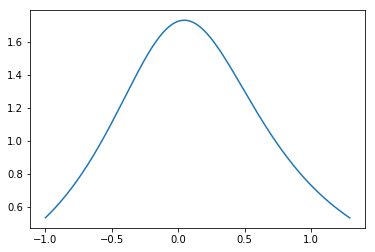

In [130]:
scale_pred(y_valid,pred)

In [53]:
pred=clip_pred(pred)

In [54]:
quadratic_weighted_kappa(y_valid,pred)

0.7264219463679968

In [181]:
raw_pred=clf.predict(d_train)

In [184]:
pred=clip_pred(raw_pred)
quadratic_weighted_kappa(y_train,pred)

0.7551281952321173

In [186]:
for s in np.arange(1.1,1.41,0.05):
    pred=(raw_pred-raw_pred.mean())*s+raw_pred.mean()
    pred=clip_pred(pred)
    print s, np.round(quadratic_weighted_kappa(y_train,pred),3)

1.1 0.771
1.15 0.776
1.2 0.78
1.25 0.782
1.3 0.783
1.35 0.783
1.4 0.782


# test pred

In [60]:
pred=clip_pred(clf.predict(xgb.DMatrix(testx)))

In [67]:
pred.shape

(1378521,)

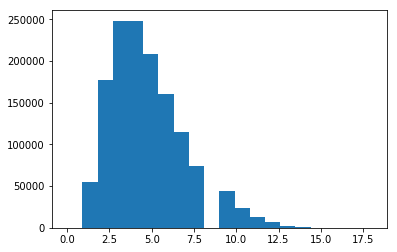

In [63]:
plt.hist(pred,bins=20);

In [68]:
sample_sub=pd.read_csv("../input/sample_submission_v2.csv",index_col=0)

In [69]:
sample_sub.shape

(1378521, 1)

In [76]:
sample_sub.head()

target
id        
0        1
1        1
2        1
3        1
4        1

In [77]:
this_sub=pd.DataFrame(pred,index=testx.index,columns=sample_sub.columns)

In [78]:
this_sub=this_sub.loc[sample_sub.index]

In [79]:
this_sub.isnull().sum()

target    0
dtype: int64

In [82]:
def make_submission(df,filepath):
    df.to_csv(filepath)
    zipfile=filepath+".7z"
    !rm {zipfile}
    !7za a {zipfile}  {filepath} > /dev/null
    !rm {filepath}

In [83]:
make_submission(this_sub,"../submission/simple_xgb.csv")

rm: cannot remove ‘../submission/simple_xgb.csv.7z’: No such file or directory


# test pred2

In [165]:
pred=(clf.predict(xgb.DMatrix(testx)))

In [166]:
pred.shape

(1378521,)

In [167]:
pred.mean()

4.688118

In [169]:
pred=(pred-pred.mean())*1.32+pred.mean()

In [171]:
pred=clip_pred(pred)

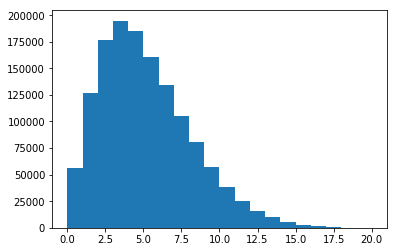

In [172]:
plt.hist(pred,bins=20);

In [173]:
sample_sub=pd.read_csv("../input/sample_submission_v2.csv",index_col=0)

In [174]:
sample_sub.shape

(1378521, 1)

In [175]:
this_sub=pd.DataFrame(pred,index=testx.index,columns=sample_sub.columns)

In [176]:
this_sub=this_sub.loc[sample_sub.index]

In [177]:
this_sub.isnull().sum()

target    0
dtype: int64

In [178]:
def make_submission(df,filepath):
    df.to_csv(filepath)
    zipfile=filepath+".7z"
    !rm {zipfile}
    !7za a {zipfile}  {filepath} > /dev/null
    !rm {filepath}

In [179]:
make_submission(this_sub,"../submission/simple_xgb_s1.32.csv")

rm: cannot remove ‘../submission/simple_xgb_s1.32.csv.7z’: No such file or directory
